In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import csv

In [2]:
# Load images
images = []
steering_angles = []

In [3]:
prefix = 'datasets/c1/0/'
image_prefix = prefix+'IMG/'
lines = [line for line in csv.reader(open(prefix+'driving_log.csv'))]

add_flip = True

for line in lines:
    source_path = line[0]
    filename = source_path.split('\\')[-1][6:]
    
    correction = 0.2
    steering_center = float(line[3])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    img_center = plt.imread(image_prefix+'center'+filename)
    img_left = plt.imread(image_prefix+'left'+filename)
    img_right = plt.imread(image_prefix+'right'+filename)
    
    images.extend([img_center, img_left, img_right])
    steering_angles.extend([steering_center, steering_left, steering_right])
    
    if add_flip:
        images.extend([
            np.fliplr(img_center),
            np.fliplr(img_left),
            np.fliplr(img_right),
        ])

        steering_angles.extend([
            steering_center*-1,
            steering_left*-1,
            steering_right*-1
        ])

In [4]:
# Convert to np.array
X_train = np.array(images)
y_train = np.array(steering_angles)  

-0.08583691 0.11416309


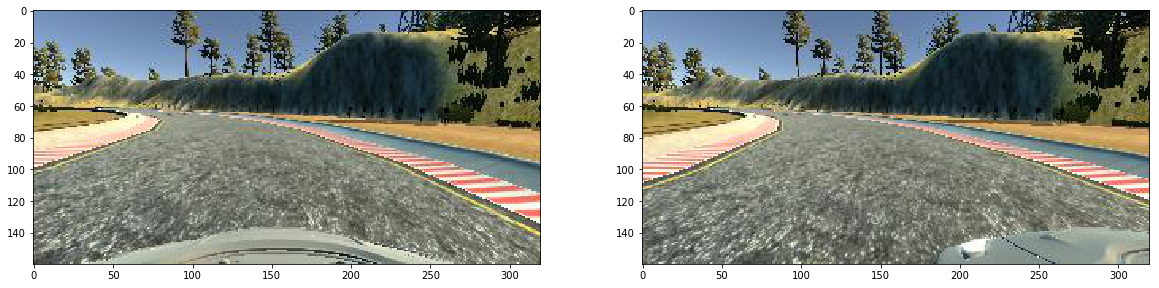

In [5]:
# Display images
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.subplot(1,2,2)
plt.imshow(X_train[1])

print(y_train[0], y_train[1])

In [6]:
# Setup keras
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


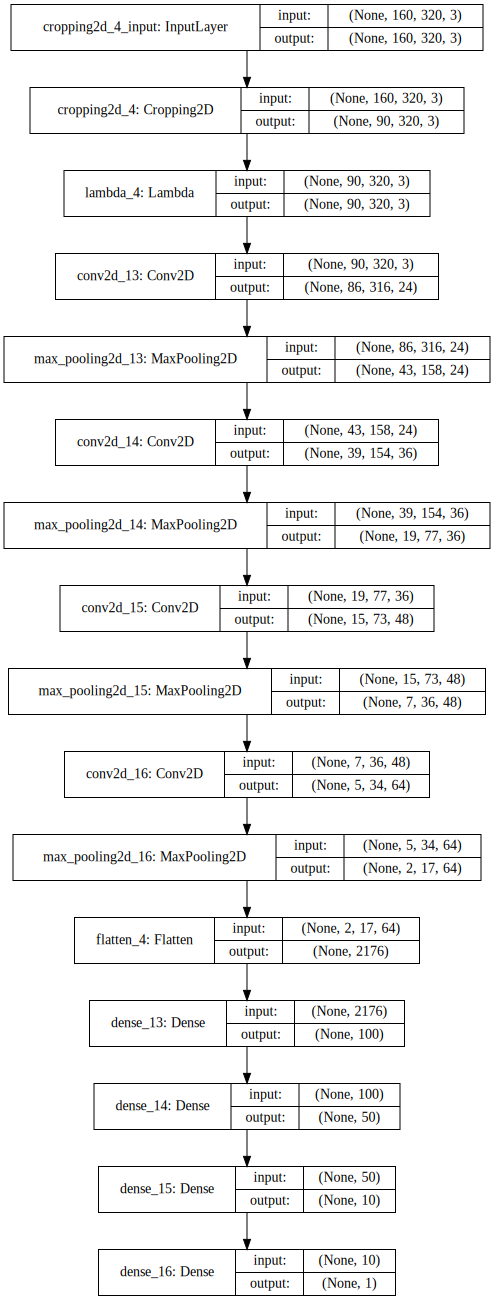

In [17]:
# Create model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Activation, Dropout, Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=X_train[0].shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(Conv2D(24,(5,5),activation='relu'))

model.add(MaxPooling2D(strides=(2,2)))

model.add(Conv2D(36,(5,5),activation='relu'))
model.add(MaxPooling2D(strides=(2,2)))

model.add(Conv2D(48,(5,5),activation='relu'))
model.add(MaxPooling2D(strides=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(strides=(2,2)))

#model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(Dropout(0.5))
#model.add(MaxPooling2D(strides=(2,2)))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
val_loss = []
loss = []

from keras.utils.vis_utils import model_to_dot 
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [19]:
# train
from sklearn.utils import shuffle
epochs = 20
for epoch in range(epochs):
    X_train, y_train = shuffle(X_train, y_train)
    stack = model.fit(X_train, y_train, validation_split=0.2,epochs=epoch+1, initial_epoch=epoch)
    val_loss += stack.history['val_loss']
    loss += stack.history['loss']
    

Train on 4694 samples, validate on 1174 samples
Epoch 1/1
4694/4694 [==============================] - 5s - loss: 0.0222 - val_loss: 0.0125
Train on 4694 samples, validate on 1174 samples
Epoch 2/2
4694/4694 [==============================] - 5s - loss: 0.0098 - val_loss: 0.0084
Train on 4694 samples, validate on 1174 samples
Epoch 3/3
4694/4694 [==============================] - 5s - loss: 0.0062 - val_loss: 0.0051
Train on 4694 samples, validate on 1174 samples
Epoch 4/4
4694/4694 [==============================] - 5s - loss: 0.0044 - val_loss: 0.0038
Train on 4694 samples, validate on 1174 samples
Epoch 5/5
4694/4694 [==============================] - 5s - loss: 0.0041 - val_loss: 0.0040
Train on 4694 samples, validate on 1174 samples
Epoch 6/6
4694/4694 [==============================] - 5s - loss: 0.0032 - val_loss: 0.0028
Train on 4694 samples, validate on 1174 samples
Epoch 7/7
4694/4694 [==============================] - 5s - loss: 0.0028 - val_loss: 0.0025
Train on 4694 sample

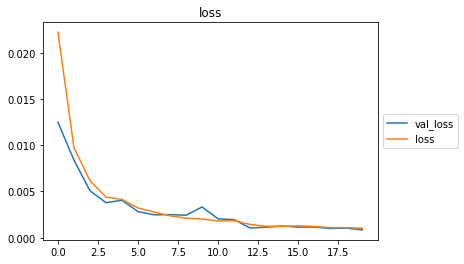

In [20]:
x = range(len(loss))
plt.plot(x, val_loss, label="val_loss")

plt.plot(x, loss, label="loss")
plt.title("loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
model.save('model.h5')